In [129]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [130]:
dno = 2

if(dno==1):
    #dataset one
    data = np.load('J0012+54_4_pulses.npy')
    times = np.linspace(0.,data.shape[1]*2e-3,data.shape[1])
    freqs = np.linspace(.4,.8,data.shape[0])
elif(dno==2):
    file = np.load('J0012+54_1_pulses.npz',allow_pickle=True)
    data = file['data']
    metadata = file['metadata'].tolist()
    times = np.linspace(0.,data.shape[1]*metadata['tsamp'],data.shape[1])
    freqs = np.linspace(.4,.8,data.shape[0])
elif(dno==3):
    data = np.load('J0012+54_4_pulses_masked.npy')
    times = np.linspace(0.,data.shape[1]*2e-3,data.shape[1])
    freqs = np.linspace(.4,.8,data.shape[0])
elif(dno==4):
    src = 'J0012+54_4_pulses.npz'
    file = np.load(src,allow_pickle=True)
    data = file['data']
    metadata = file['metadata'].tolist()
    times = np.linspace(0.,data.shape[1]*metadata['tsamp'],data.shape[1])
    freqs = np.linspace(.4,.8,data.shape[0])


(1024, 7629)


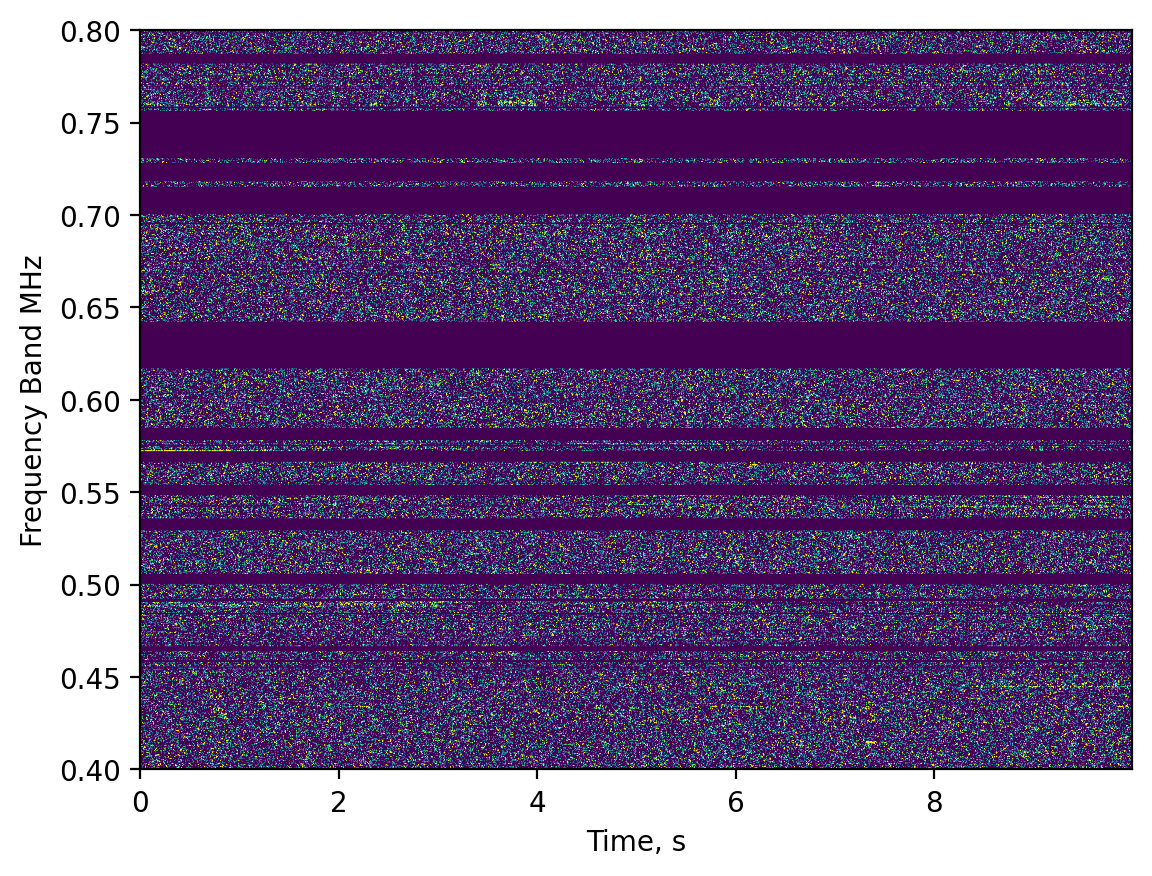

In [131]:
print(data.shape)
fig,ax=plt.subplots(1,1,dpi=200)
ax.imshow(data,aspect='auto',extent=(times[0],times[-1],freqs[0],freqs[-1]),vmin=-0.,vmax=.5)
ax.set_ylabel('Frequency Band MHz')
ax.set_xlabel('Time, s')
plt.show()

In [132]:
def t_delay_freq(const, f):
    """Return delay, with a generic constant out front, in units of time"""
    return const * (1.0 / f**2)


def surrogate_function(t, f, t_offset, amplitude, pulse_width, delay_const):
    offwid_factor = 4.
    return amplitude * (
        np.exp(
            -((t - t_offset - t_delay_freq(delay_const, f)) ** 2)
            / (2 * pulse_width**2)
        )
        / np.sqrt(2 * np.pi * pulse_width**2)
        - np.exp(
            -((t - t_offset - t_delay_freq(delay_const, f)) ** 2)
            / (2 * (offwid_factor * pulse_width) ** 2)
        )
        / np.sqrt(2 * np.pi * (offwid_factor * pulse_width) ** 2)
    )


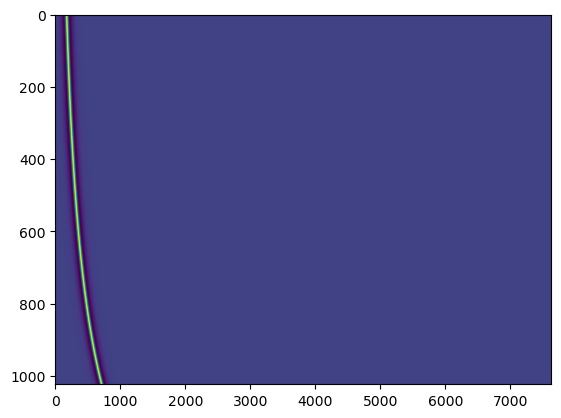

In [133]:
times_mesh, freq_mesh = np.meshgrid(times, freqs[::-1])
surrogate_data = surrogate_function(times_mesh,freq_mesh,0.0,1.,20e-3,150e-3)
plt.imshow(surrogate_data,aspect='auto')#,extent=(times[0],times[-1],freqs[-1],freqs[0]))
plt.show()


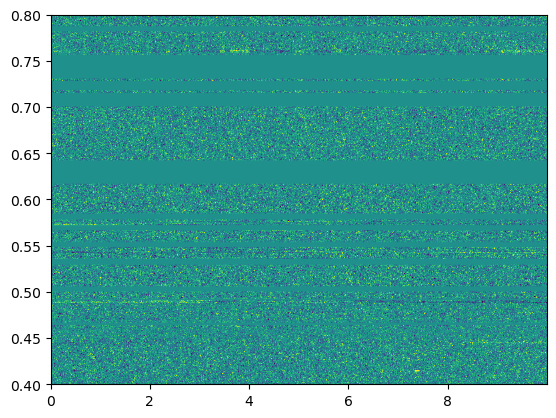

In [134]:
plt.imshow(data,aspect='auto',vmin=-.5,vmax=.5,extent=(times[0],times[-1],freqs[0],freqs[-1]))

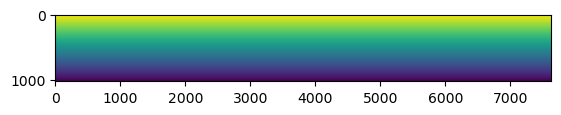

In [135]:
plt.imshow(freq_mesh)

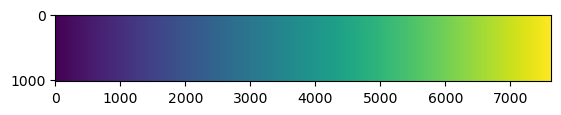

In [136]:
plt.imshow(times_mesh)

In [137]:
#coarsening the data file
print("start coarsening")
data_coarsened = np.zeros(shape=(100, 1000))
times_coarsened_edges = np.linspace(
    times[0], times[-1], data_coarsened.shape[1] + 1, endpoint=True
)
freqs_coarsened_edges = np.linspace(
    freqs[0], freqs[-1], data_coarsened.shape[0] + 1, endpoint=True
)
weighted = np.histogram2d(
    freq_mesh.flatten(),
    times_mesh.flatten(),
    bins=(freqs_coarsened_edges, times_coarsened_edges),
    weights=data.flatten(),
)
counts = np.histogram2d(
    freq_mesh.flatten(),
    times_mesh.flatten(),
    bins=(freqs_coarsened_edges, times_coarsened_edges),
)
data_coarsened[:, :] = weighted[0] / counts[0]
times_coarsened = 0.5 * (times_coarsened_edges[1:] + times_coarsened_edges[:-1])
freqs_coarsened = 0.5 * (freqs_coarsened_edges[1:] + freqs_coarsened_edges[:-1])

print("fin coarsening")


start coarsening
fin coarsening


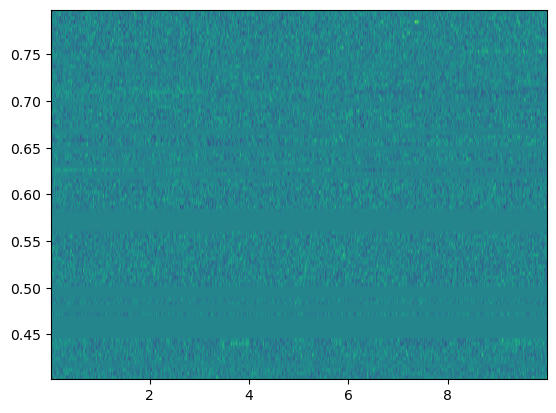

In [138]:
plt.imshow(
    data_coarsened,
    extent=(
        times_coarsened[0],
        times_coarsened[-1],
        freqs_coarsened[0],
        freqs_coarsened[-1],
    ),
    aspect="auto",
)
plt.show()

In [139]:
#sampling array
dms = np.geomspace(120,140) * 1e-3 * 4.149
toffsets = np.linspace(0,times[-1],150)

In [140]:
def compute_gini_for_fit(surrogate_data, data, freqs, plot=False):
    frequency_contributions = np.sum(surrogate_data * data, axis=1)
    freqs_normed = (freqs - freqs[0]) / (freqs[-1] - freqs[0])
    if plot:
        plt.plot(
            freqs_normed,
            np.cumsum(frequency_contributions) / np.sum(frequency_contributions),
        )
        plt.show()
    gini_index = np.trapz(
        np.abs(
            freqs_normed
            - np.cumsum(frequency_contributions) / np.sum(frequency_contributions)
        ),
        freqs_normed,
    )
    return gini_index


In [141]:
times_mesh_coarse, freq_mesh_coarse = np.meshgrid(times_coarsened, freqs_coarsened)

def calculate_fit_qualities(data,time_mesh,freq_mesh):
    fit_quality = np.zeros(shape=(dms.size, toffsets.size))
    ginis = np.zeros(shape=fit_quality.shape)
    for i, dm in tqdm(enumerate(dms)):
        for j, toff in enumerate(toffsets):
            surrogate_data = surrogate_function(
                times_mesh_coarse, freq_mesh_coarse, toff, 1.0, 40e-3, dm
            )
            fit_quality[i, j] = np.sum(data_coarsened * surrogate_data)
            ginis[i, j] = compute_gini_for_fit(
                surrogate_data, data_coarsened, freqs_coarsened, plot=False
            )
    return fit_quality,ginis

coarsen=False
if(coarsen):
    fit_quality,ginis=calculate_fit_qualities(data_coarsened,times_mesh_coarse,freq_mesh_coarse)
else:
    fit_quality,ginis=calculate_fit_qualities(data,times_mesh,freq_mesh)


50it [01:37,  1.95s/it]


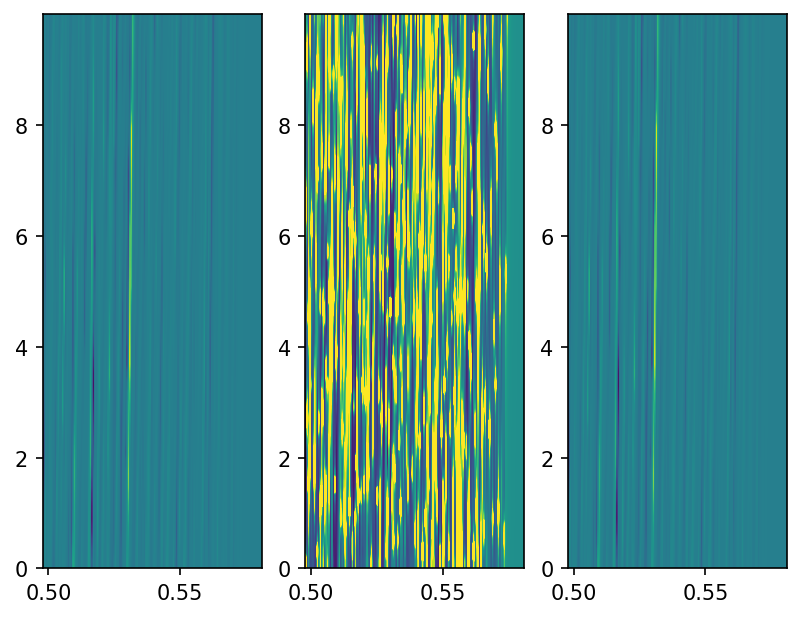

In [142]:

weighted_quality = fit_quality
mask = np.isnan(ginis)
weighted_quality[mask] = 0.0
weighted_quality[np.logical_not(mask)] /= ginis[np.logical_not(mask)]

# plt.imshow(fit_quality)
fig, ax = plt.subplots(1, 3, dpi = 150)
ax[0].imshow(fit_quality, extent=(dms[0], dms[-1], toffsets[0], toffsets[-1]),aspect='auto')
# ax[0].set_xscale("log")
ax[1].imshow(ginis, extent=(dms[0], dms[-1], toffsets[0], toffsets[-1]),aspect='auto',vmin=0,vmax=1)
# ax[1].set_xscale("log")
ax[2].imshow(weighted_quality, extent=(dms[0], dms[-1], toffsets[0], toffsets[-1]),aspect='auto')
# ax[2].set_xscale("log")
plt.show()


In [143]:

fit_inds = np.unravel_index(fit_quality.argmax(), fit_quality.shape)
print(fit_inds)
# fit_inds = np.unravel_index(fit_quality.argmax(),fit_quality.shape)
dm_opt, toffset_opt = dms[fit_inds[0]], toffsets[fit_inds[1]]
print("best:", dm_opt, toffset_opt)


fit_inds = np.unravel_index(weighted_quality.argmax(), fit_quality.shape)
print(fit_inds)
dm_opt, toffset_opt = dms[fit_inds[0]], toffsets[fit_inds[1]]
print("best with gini:", dm_opt, toffset_opt)

(30, 59)
best: 0.5471576949033335 3.9595267779865773
(30, 59)
best with gini: 0.5471576949033335 3.9595267779865773


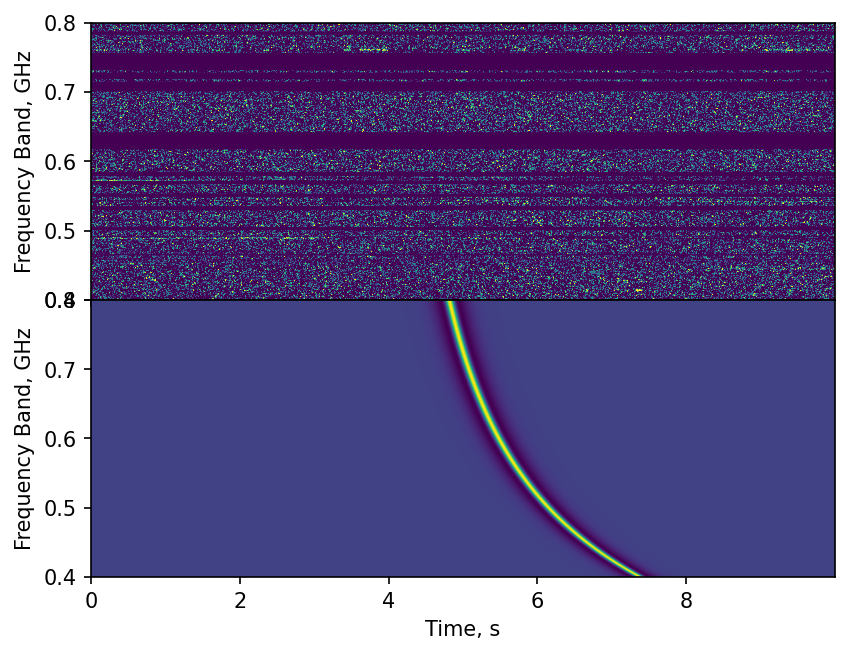

In [153]:
fig, ax = plt.subplots(2, 1, dpi=150,sharex=True)
surrogate_data = surrogate_function(
    times_mesh, freq_mesh, toffset_opt, 1.0, 40e-3, dm_opt
)
ax[0].imshow(
    data,
    extent=(
        times[0],
        times[-1],
        freqs[0],
        freqs[-1],
    ),
    aspect="auto",
    vmin=-.0,vmax=0.35
)
ax[1].imshow(
    surrogate_data,
    extent=(
        times[0],
        times[-1],
        freqs[0],
        freqs[-1],
    ),
    aspect="auto",
)


for axis in ax:
    axis.set_ylabel('Frequency Band, GHz')
ax[1].set_xlabel('Time, s')

fig.subplots_adjust(hspace=0)
    
plt.show()


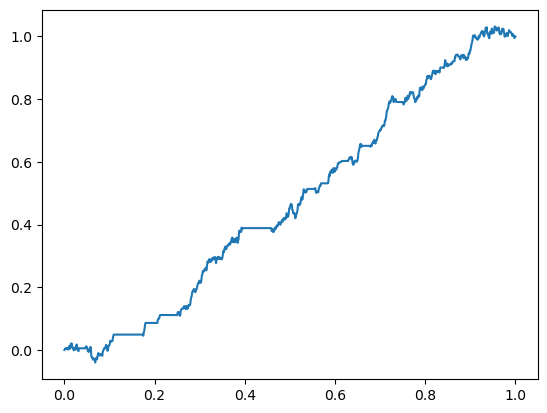

gini index:  0.05789754747391247


In [145]:

surrogate_data = surrogate_function(
    times_mesh,freq_mesh, toffset_opt, 1.0, 40e-3, dm_opt
)
gini_index = compute_gini_for_fit(
    surrogate_data, data,freqs, plot=True
)

print("gini index: ", gini_index)
plt.show()

In [146]:
dm_opt / 1e-3 /  4.149377593360996 

131.86500447170337

In [147]:
toffset_opt

3.9595267779865773

In [148]:
dms / 1e-3 / 4.149

array([120.        , 120.37810631, 120.75740398, 121.13789678,
       121.51958847, 121.90248282, 122.28658364, 122.67189471,
       123.05841985, 123.44616288, 123.83512765, 124.22531801,
       124.61673781, 125.00939093, 125.40328125, 125.79841268,
       126.19478912, 126.5924145 , 126.99129276, 127.39142783,
       127.79282368, 128.19548428, 128.59941362, 129.0046157 ,
       129.41109452, 129.81885411, 130.22789851, 130.63823175,
       131.04985791, 131.46278106, 131.87700528, 132.29253467,
       132.70937335, 133.12752544, 133.54699508, 133.96778642,
       134.38990363, 134.81335088, 135.23813236, 135.66425229,
       136.09171486, 136.52052433, 136.95068492, 137.3822009 ,
       137.81507653, 138.24931611, 138.68492393, 139.1219043 ,
       139.56026154, 140.        ])

In [149]:
weighted_quality.shape
tuples = []
for i in range(weighted_quality.shape[0]):
    for j in range(weighted_quality.shape[1]):
        tup = (weighted_quality[i,j],i,j)
        tuples.append(tup)

(1785.7322645163033, 30, 59)
(1782.1367223107695, 31, 59)
(1699.8401660265986, 29, 59)
(1657.7552706692777, 11, 60)
(1629.233432764014, 10, 60)
(1609.1271733548976, 28, 59)
(1591.1347861964523, 12, 60)
(1518.7872628156235, 27, 59)
(1504.062186046147, 13, 60)
(1419.68894104743, 32, 59)
(1417.3567599098355, 26, 59)
(1389.5936299925554, 14, 60)
(1332.1780893111038, 25, 59)
(1273.0968895989686, 15, 60)


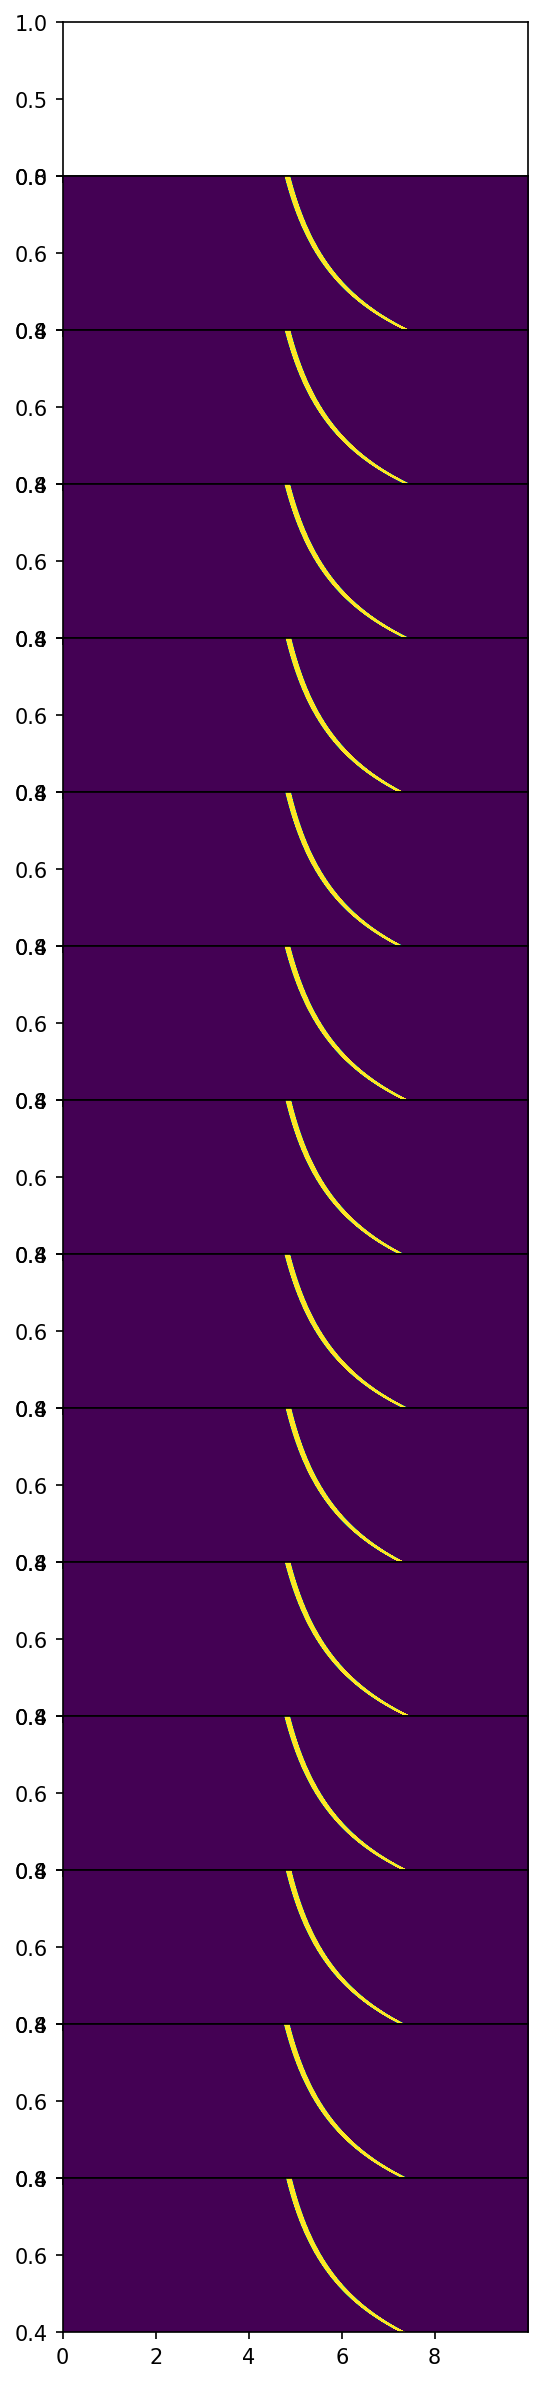

In [150]:
tuples = sorted(tuples,key = lambda tup : tup[0])

fig, ax = plt.subplots(15,1, dpi=150,figsize = [4,20],sharex=True)
for i in range(1,15):
    tup = tuples[-i] 
    print(tup)
    surrogate_data = surrogate_function(
        times_mesh, freq_mesh, toffsets[tup[2]], 1.0, 40e-3, dms[tup[1]]
    )
    ax[i].imshow(
        surrogate_data,
        extent=(
            times[0],
            times[-1],
            freqs[0],
            freqs[-1],
        ),
        aspect="auto",
        vmin=-.0,vmax=1.5
    )

fig.subplots_adjust(hspace=0.)
plt.show()

In [151]:
print(dms[45]*1e-3*4.19)
print(dms[28]*1e-3*4.19)

0.0024033689685844096
0.0022782113553959865
